# Coordinate systems and transforms of Synthesis AI dataset

First, we install `synthesisai` and download test datasets.

In [ ]:
%%bash
python -m pip install synthesisai
curl https://synthesisai-example-datasets.s3.amazonaws.com/humans_api_example_dataset.zip -o humans_api_example_dataset.zip
unzip humans_api_example_dataset.zip -d humans_api_example_dataset

Finally we add some imports for the visualisation.

In [1]:
%matplotlib inline

In [2]:
import cv2
import numpy as np

We use `SaiDataset` class to access synthesis datasets.


In [3]:
from synthesisai import SaiDataset, Modality

In [4]:
data_root = "humans_api_example_dataset"
dataset = SaiDataset(
    data_root,
    modalities=[
        Modality.RGB, Modality.CAM_TO_HEAD, Modality.HEAD_TO_CAM,
        Modality.WORLD_TO_HEAD, Modality.HEAD_TO_WORLD, Modality.WORLD_TO_CAM,
        Modality.CAM_TO_WORLD, Modality.LANDMARKS_3D_IBUG68
    ]
)

In [5]:
len(dataset)

50

There are 50 items in the test dataset. Let's explore them closer.

In [6]:
item = dataset[0]
item2 = dataset[1]

Each item is a dict with different modalities as keys.

In [7]:
print(item.keys())

dict_keys([<Modality.RGB: 2>, <Modality.LANDMARKS_3D_IBUG68: 14>, <Modality.HEAD_TO_CAM: 28>, <Modality.CAM_TO_HEAD: 29>, <Modality.HEAD_TO_WORLD: 30>, <Modality.WORLD_TO_HEAD: 31>, <Modality.CAM_TO_WORLD: 32>, <Modality.WORLD_TO_CAM: 33>])


In the Synthesis AI dataset we use 3 different coordinate systems:
1.  World coordinate system.
2.  Camera coordinate system, centered at the camera with x-axis directed right, y-axis directed top and z-axis directed towards the camera.
3.  Head coordinate system, centered at the center of the face with x-axis directed toward the left ear, y-axis directed to the top of the head and z-axis directed towards the nose.

We provide transformations between head, camera and world coordinates systems as 4x4 matrices in homogeneous coordinates.

In [8]:
item[Modality.CAM_TO_HEAD]

{1: array([[ 9.99998727e-01, -8.78708453e-08,  4.42647876e-08,
         -1.55687252e-08],
        [-4.62436546e-09,  9.99998860e-01, -6.47808811e-07,
         -5.21423455e-07],
        [-5.82861084e-08,  6.75191251e-07,  9.99998655e-01,
          9.99998781e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]])}

In [9]:
item[Modality.HEAD_TO_CAM]

{1: array([[ 1.00000127e+00,  8.78710872e-08, -4.42648466e-08,
          5.98335834e-08],
        [ 4.62441438e-09,  1.00000114e+00,  6.47810421e-07,
         -1.26385581e-07],
        [ 5.82862578e-08, -6.75192924e-07,  1.00000135e+00,
         -1.00000013e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]])}

In [10]:
item[Modality.HEAD_TO_WORLD]

{1: array([[ 0.99874067,  0.00310815,  0.05009945,  0.07918648],
        [ 0.0103344 ,  0.96396834, -0.26582056,  1.58719778],
        [-0.0491204 ,  0.26600313,  0.96272123,  0.36950338],
        [ 0.        ,  0.        ,  0.        ,  1.        ]])}

In [11]:
item[Modality.WORLD_TO_HEAD]

{1: array([[ 0.99873813,  0.01033429, -0.04912031, -0.07733901],
        [ 0.00310805,  0.96396613,  0.26600256, -1.62853986],
        [ 0.0500993 , -0.26581982,  0.96271865,  0.06221365],
        [ 0.        ,  0.        ,  0.        ,  1.        ]])}

In [12]:
item[Modality.CAM_TO_WORLD]

array([[ 0.9987394 ,  0.00310809,  0.05009943,  0.12928586],
       [ 0.0103344 ,  0.96396706, -0.26582083,  1.32137704],
       [-0.04912039,  0.26600348,  0.96271976,  1.3322233 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [13]:
item[Modality.WORLD_TO_CAM]

array([[ 0.9987394 ,  0.0103344 , -0.04912039, -0.07733919],
       [ 0.00310809,  0.96396706,  0.26600348, -1.6285418 ],
       [ 0.05009943, -0.26582083,  0.96271976, -0.9377853 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

X_TO_Y transform is always inverse of Y_TO_X:

In [14]:
human_instance_ids = item[Modality.CAM_TO_HEAD].keys()
# each human has its own cam-to-head and head-to-cam transform
for human_instance_id in human_instance_ids:
    np.testing.assert_allclose(item[Modality.CAM_TO_HEAD][human_instance_id] @ item[Modality.HEAD_TO_CAM][human_instance_id], np.eye(4), atol=1e-10)
    np.testing.assert_allclose(item[Modality.HEAD_TO_WORLD][human_instance_id] @ item[Modality.WORLD_TO_HEAD][human_instance_id], np.eye(4), atol=1e-10)
np.testing.assert_allclose(item[Modality.CAM_TO_WORLD] @ item[Modality.WORLD_TO_CAM], np.eye(4), atol=1e-10)

And composition of X_TO_Y and Z_TO_X transforms always give Z_TO_Y transform:

In [15]:
for human_instance_id in human_instance_ids:
    np.testing.assert_allclose(item[Modality.CAM_TO_WORLD], item[Modality.HEAD_TO_WORLD][human_instance_id] @ item[Modality.CAM_TO_HEAD][human_instance_id], atol=1e-10)

All 3D coordinates (ex. landmarks) are always given in camera coordinates.

In [16]:
item[Modality.LANDMARKS_3D_IBUG68][1][0]

(-0.0750153586268425, -0.002459546085447073, -1.041256308555603)

If we want to get coordinates in the head coordinate system (they should be independent on camera position and pitch/yaw/roll values),
we need to multiply them by CAM_TO_HEAD transform.

However, as matrices are in homogeneous coordinates, first we will need to transform them to homogeneous coordinates:

In [17]:
def to_homogeneous(xs):
    xs_array = np.array(xs)
    assert (xs_array.shape[-1] == 3)
    ones_shape = list(xs_array.shape)
    ones_shape[-1] = 1
    homogeneous = np.concatenate([xs_array, np.ones(ones_shape)], axis=-1)
    return homogeneous

In [18]:
homogeneous_cam = to_homogeneous(item[Modality.LANDMARKS_3D_IBUG68][1][0])
homogeneous_cam

array([-0.07501536, -0.00245955, -1.04125631,  1.        ])

We wrote our own function instead of using opecv one, so it can work with multidimensional arrays of points.
Opencv function can work only with 1-d arrays of points, neither single point, nor multidimensional arrays are supported.
In this particular case, opencv function will suffice:

In [19]:
cv2.convertPointsToHomogeneous(np.array([item[Modality.LANDMARKS_3D_IBUG68][1][0]]))[0]

array([[-0.07501536, -0.00245955, -1.04125631,  1.        ]])

Now, we can compute homogeneous coordinates in head coordinate system.

In [20]:
homogeneous_head = item[Modality.CAM_TO_HEAD][1] @ homogeneous_cam
homogeneous_head

array([-0.07501532, -0.00245939, -0.04125612,  1.        ])

Now, we need to transform back to euclidian coordinates:

In [21]:
def from_homogeneous(xs):
    xs_array = np.array(xs)
    assert (xs_array.shape[-1] == 4)

    slice_but_last = list(xs_array.shape)
    slice_but_last[-1] = slice(None, -1)
    slice_but_last = tuple(slice_but_last)

    slice_last = list(xs_array.shape)
    slice_last[-1] = slice(-1, None)
    slice_last = tuple(slice_last)

    return xs_array[slice_but_last] / xs_array[slice_last]

And we can compute euclidian coordinates in the head space as:

In [22]:
from_homogeneous(homogeneous_head)

array([-0.07501532, -0.00245939, -0.04125612])

Once again, we can use opencv convertion function:

In [23]:
cv2.convertPointsFromHomogeneous(np.array([homogeneous_head]))[0]

array([[-0.07501532, -0.00245939, -0.04125612]])

We can use these transforms to estimate pitch/yaw/roll values (rotation of the head, relative to the world).

In [24]:
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt


In [25]:
def get_yaw_pitch_roll_world(item, human_instance_id):
    rotation = R.from_matrix(item[Modality.WORLD_TO_HEAD][human_instance_id][:3,:3])

    # We multiply resulting angles by [-1, 1, -1] to use the same positive axis
    # as in job generaton json.
    yaw, pitch, roll = rotation.as_euler("YXZ", degrees=True) * [-1, 1,-1]
    return yaw, pitch, roll

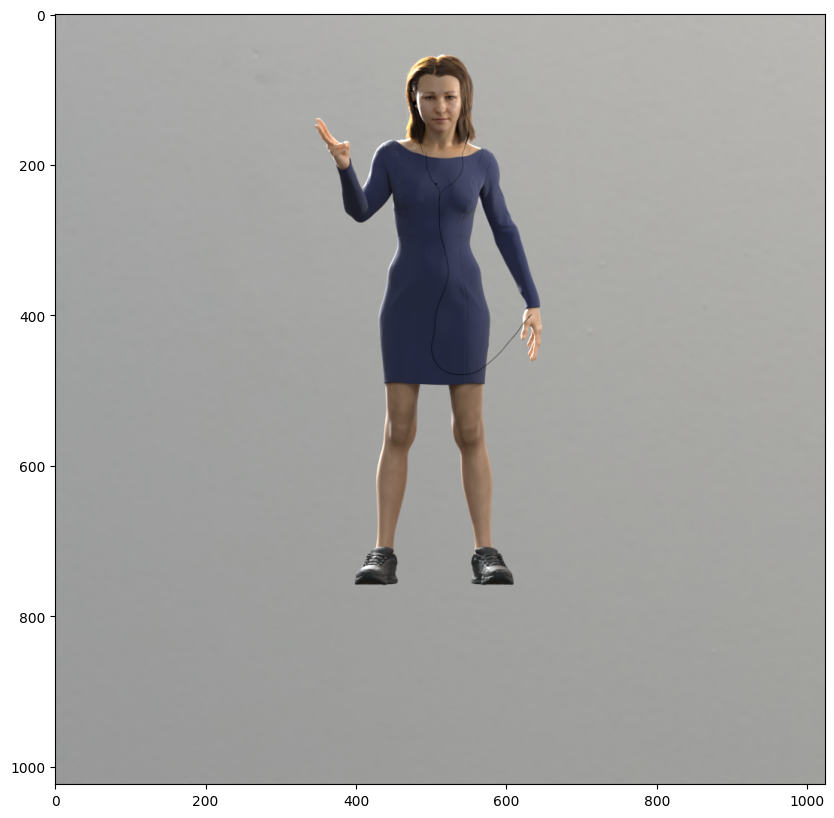

In [27]:
item = dataset[30]
plt.figure(figsize=(10,10))
plt.imshow(item[Modality.RGB])

In [28]:
get_yaw_pitch_roll_world(item, 1)

(-0.5922517438879105, -13.963883261770814, 1.581841420961486)

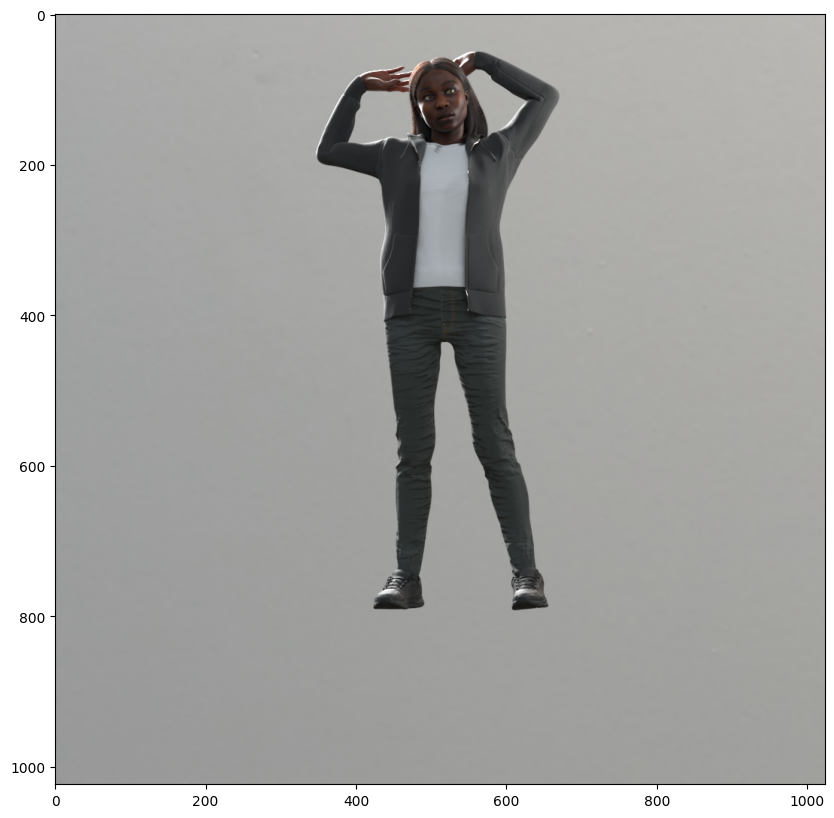

In [30]:
item = dataset[40]
plt.figure(figsize=(10,10))
plt.imshow(item[Modality.RGB])

In [31]:
get_yaw_pitch_roll_world(item, 1)


(-3.965838080370218, -5.71823364290839, 16.208101781072415)